In [12]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [13]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 20", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

# for fname in ['scf.hdf5','ci.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 0  2S+1 = 1


In [14]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes, linemin, wftools
modules = [recipes, linemin, wftools]
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, nconfig=200, verbose=True)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/recipes.py(425)initialize_qmc_objects()
    423     import pdb
    424     pdb.set_trace()
--> 425     wf, to_opt = wftools.generate_wf(
    426         mol, mf, mc=mc, jastrow_kws=jastrow_kws, slater_kws=slater_kws
    427     )



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(196)generate_wf()
    194     import pdb
    195     pdb.set_trace()
--> 196     wf1, to_opt1 = generate_slater(mol, mf, mc=mc, **slater_kws)
    197 
    198     pack = [jast(mol, **kw) for jast, kw in zip(jastrow, jastrow_kws)]



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(119)generate_jastrow()
    117     import pdb
    118     pdb.set_trace()
--> 119     if ion_cusp == False:
    120         ion_cusp = []
    121         if not mol.has_ecp():



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(100)default_jastrow_basis()
     98     import pdb
     99     pdb.set_trace()
--> 100     if ion_cusp:
    101         abasis = [func3d.CutoffCuspFunction(gamma=24, rcut=rcut)]
    102     else:



ipdb>  c


starting warmup
finished warmup
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(195)line_minimization()
    193     import pdb
    194     pdb.set_trace()
--> 195     x0 = pgrad_acc.transform.serialize_parameters(wf.parameters)
    196 
    197     df = []



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(167)gradient_energy_function()
    165         import pdb
    166         pdb.set_trace()
--> 167         newparms = pgrad_acc.transform.deserialize(wf, x)
    168         for k in newparms:
    169             wf.parameters[k] = newparms[k]



ipdb>  c


----------vmc done
descent en -2.761961692974385 0.04979480231235682  estimated sigma  7.0420484765822176
descent |grad| 0.7092861528407304
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(222)line_minimization()
    220         # We don't use the above computed value because we are
    221         # doing correlated sampling.
--> 222         steps = np.linspace(-steprange / (npts - 2), steprange, npts)
    223         params = [x0 + update(pgrad, Sij, step, **update_kws) for step in steps]
    224         if client is None:



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(273)correlated_compute()
    271     import pdb
    272     pdb.set_trace()
--> 273     psi0 = wf.recompute(configs)[1]  # recompute gives logdet
    274 
    275     current_state = np.random.get_state()



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(234)line_minimization()
    232 
    233         stepsdata["weight"] = (
--> 234             stepsdata["weight"] / np.mean(stepsdata["weight"], axis=1)[:, np.newaxis]
    235         )
    236         en = np.real(np.mean(stepsdata["total"] * stepsdata["weight"], axis=1))



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(167)gradient_energy_function()
    165         import pdb
    166         pdb.set_trace()
--> 167         newparms = pgrad_acc.transform.deserialize(wf, x)
    168         for k in newparms:
    169             wf.parameters[k] = newparms[k]



ipdb>  c


----------vmc done
descent en -2.8645721736162857 0.010851441584945604  estimated sigma  1.534625586072947
descent |grad| 0.1259798396769476
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(217)line_minimization()
    215         yfit = []
    216         import pdb
--> 217         pdb.set_trace()
    218         # Calculate samples to fit.
    219         # include near zero in the fit, and go backwards as well



ipdb>  
ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(273)correlated_compute()
    271     import pdb
    272     pdb.set_trace()
--> 273     psi0 = wf.recompute(configs)[1]  # recompute gives logdet
    274 
    275     current_state = np.random.get_state()



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(234)line_minimization()
    232 
    233         stepsdata["weight"] = (
--> 234             stepsdata["weight"] / np.mean(stepsdata["weight"], axis=1)[:, np.newaxis]
    235         )
    236         en = np.real(np.mean(stepsdata["total"] * stepsdata["weight"], axis=1))



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(167)gradient_energy_function()
    165         import pdb
    166         pdb.set_trace()
--> 167         newparms = pgrad_acc.transform.deserialize(wf, x)
    168         for k in newparms:
    169             wf.parameters[k] = newparms[k]



ipdb>  c


----------vmc done
descent en -2.8276099423545893 0.01324209949889992  estimated sigma  1.8727156705638233
descent |grad| 0.17556682616147654
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(217)line_minimization()
    215         yfit = []
    216         import pdb
--> 217         pdb.set_trace()
    218         # Calculate samples to fit.
    219         # include near zero in the fit, and go backwards as well



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(273)correlated_compute()
    271     import pdb
    272     pdb.set_trace()
--> 273     psi0 = wf.recompute(configs)[1]  # recompute gives logdet
    274 
    275     current_state = np.random.get_state()



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(234)line_minimization()
    232 
    233         stepsdata["weight"] = (
--> 234             stepsdata["weight"] / np.mean(stepsdata["weight"], axis=1)[:, np.newaxis]
    235         )
    236         en = np.real(np.mean(stepsdata["total"] * stepsdata["weight"], axis=1))



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(167)gradient_energy_function()
    165         import pdb
    166         pdb.set_trace()
--> 167         newparms = pgrad_acc.transform.deserialize(wf, x)
    168         for k in newparms:
    169             wf.parameters[k] = newparms[k]



ipdb>  c


----------vmc done
descent en -2.8936917841155956 0.0035804332659853774  estimated sigma  0.5063497283928317
descent |grad| 0.10277074348446368
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(217)line_minimization()
    215         yfit = []
    216         import pdb
--> 217         pdb.set_trace()
    218         # Calculate samples to fit.
    219         # include near zero in the fit, and go backwards as well



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(273)correlated_compute()
    271     import pdb
    272     pdb.set_trace()
--> 273     psi0 = wf.recompute(configs)[1]  # recompute gives logdet
    274 
    275     current_state = np.random.get_state()



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/linemin.py(234)line_minimization()
    232 
    233         stepsdata["weight"] = (
--> 234             stepsdata["weight"] / np.mean(stepsdata["weight"], axis=1)[:, np.newaxis]
    235         )
    236         en = np.real(np.mean(stepsdata["total"] * stepsdata["weight"], axis=1))



ipdb>  c


,energy,iteration,error,fname
0,-2.761962,0,0.049795,sj.hdf5
1,-2.864572,1,0.010851,sj.hdf5
2,-2.827610,2,0.013242,sj.hdf5
3,-2.893692,3,0.003580,sj.hdf5


In [19]:
tstep = 0.1
nconfig = 200
nsteps = 200
discard = 1500

In [20]:
#PYQMC VMC with jastrow
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
VMC("scf.hdf5", "vmc-j-001.hdf5",  load_parameters="sj.hdf5", verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/recipes.py(425)initialize_qmc_objects()
    423     import pdb
    424     pdb.set_trace()
--> 425     wf, to_opt = wftools.generate_wf(
    426         mol, mf, mc=mc, jastrow_kws=jastrow_kws, slater_kws=slater_kws
    427     )



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(196)generate_wf()
    194     import pdb
    195     pdb.set_trace()
--> 196     wf1, to_opt1 = generate_slater(mol, mf, mc=mc, **slater_kws)
    197 
    198     pack = [jast(mol, **kw) for jast, kw in zip(jastrow, jastrow_kws)]



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(119)generate_jastrow()
    117     import pdb
    118     pdb.set_trace()
--> 119     if ion_cusp == False:
    120         ion_cusp = []
    121         if not mol.has_ecp():



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(100)default_jastrow_basis()
     98     import pdb
     99     pdb.set_trace()
--> 100     if ion_cusp:
    101         abasis = [func3d.CutoffCuspFunction(gamma=24, rcut=rcut)]
    102     else:



ipdb>  c


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------vmc done


Mean  etot_j ,  -2.8767780034783796 +/- 0.0031826878147980025
Mean  ee_j ,  0.946977728753744 +/- 0.0021924015641115384
Mean  ei_j ,  -6.560321676552433 +/- 0.09684878971927922
Mean  ke_j ,  2.7365659443203096 +/- 0.09031338387274442


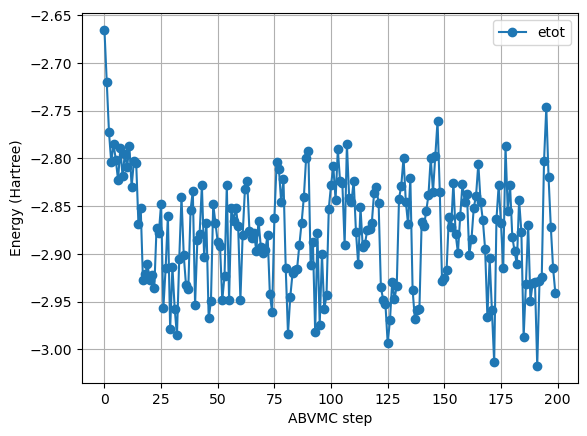

In [22]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
with h5py.File("vmc-j-001.hdf5") as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
# plt.plot(ee_j, marker='o', label="ee")
# plt.plot(ei_j, marker='o', label="ei")
# plt.plot(ke_j, marker='o', label="ke")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
# plt.xlim((200,500))
# plt.ylim((-10, 5))
plt.grid()
# plt.figure()
discard = 100
for e in [etot_j, ee_j, ei_j, ke_j]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    print("Mean ", namestr(e, globals())[0], ", ", e_m, "+/-", e_d)

# e_m = np.mean(etot[discard:])
# e_d = np.var(etot[discard:])
# # e_m2 = np.mean(etot2[discard:])
# # e_d2 = np.var(etot2[discard:])
# print("Mean VMC Energy, ", e_m, "+/-", e_d)
# print("LDA Energy, ", mf.energy_tot())
# plt.plot(ed, marker='o', label="ke")

# print('ee', np.mean(ee[discard:]))
# print('ei', np.mean(ei[discard:]))
# print('ke', np.mean(ke[discard:]))


In [44]:
#ABVMC with jastrows
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", load_parameters="sj.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot_j_abvmc ,  -2.8367256737984303 +/- 0.006814033520803423
LDA Energy,  -2.826706554186113


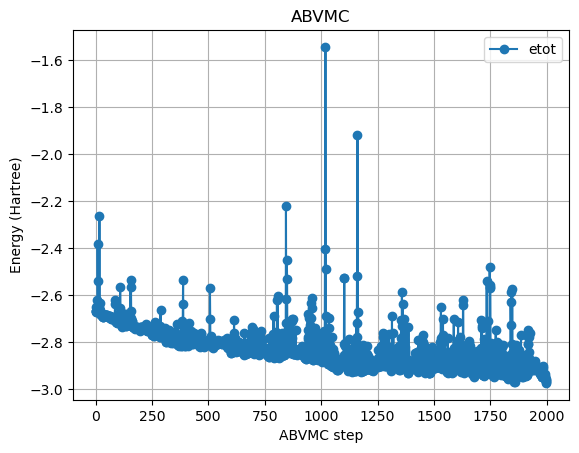

In [45]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



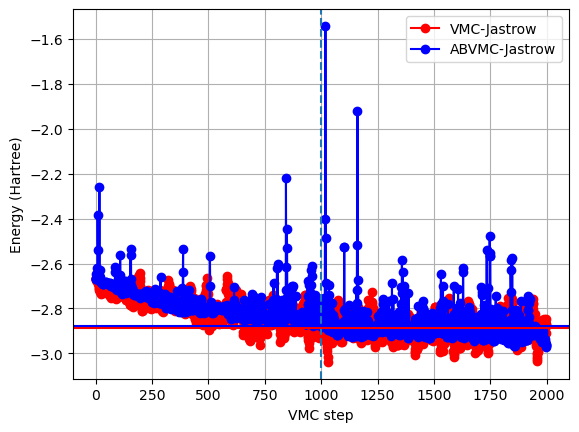

In [46]:
plt.plot(etot_j, marker='o', color = 'r', label="VMC-Jastrow")
plt.plot(etot_j_abvmc, marker='o', color='b', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
discard =  1000
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot_j[discard:]), color='r')
plt.axhline(np.mean(etot_j_abvmc[discard:]), color='b')
plt.grid()
